### CPL model 

\begin{equation}
E(z)=\frac{H(z)}{H_0} =\sqrt{\Omega_{m,0} (1+z)^3 + \Omega_{\Lambda,0}(1+z)^{3(1+\omega_0 + \omega_a)} \, \text{exp} \left(-\frac{3\omega_a z}{1+z} \right)}.
\end{equation}

when $z=0$, $\Lambda = 3H_0^2(1-\Omega_{m,0})$

\begin{equation}
    d_L= \int_0^z \frac{dz'}{E(z')} = \int_0^z \frac{dz'}{\sqrt{\Omega_{m,0} (1+z)^3 + \Omega_{\Lambda,0}(1+z)^{3(1+\omega_0 + \omega_a)} \, \text{exp} \left(-\frac{3\omega_1 z}{1+z} \right)}} 
\end{equation}



---

\begin{equation}
\frac{d_L}{dz} = \frac{1}{E(z)}
\end{equation}

---


$\omega_a \in [-8,3]$
$\omega_0 \in [-3,3]$

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import mplcyberpunk
import tqdm
from functions import nth_derivative#, Param_dirich
plt.style.use('cyberpunk')
from scipy.integrate import quad

#### There are two methods within the PINN paradigm: 

#### 1. To meet the bpundary and initial conditions by a reparametrization of the ANN

Here we have an initial value problem. Then we can reparametrize the solution as:

$$ANN(z,x_0) ---> Param(x,x_0) $$



$$Param(z,x_0) = x_0 + (1-e^{-(z-z_0)})ANN(z)$$

In [2]:
#Real solution


# Definimos los parámetros cosmológicos
Omega_m0 = 0.3
Omega_Lambda0 = 0.7
omega_0 = 1.0
omega_a = 1.0

# Función a integrar
def integrand(z):
    return 1 / np.sqrt(Omega_m0 * (1 + z)**3 + Omega_Lambda0 * (1 + z)**(3 * (1 + omega_0 + omega_a)) * np.exp(-3 * omega_a * z / (1 + z)))


def DL(z):
    # Límite inferior de la integral
    z_min = 0.0

    # Límite superior de la integral
    #z_max = 3.0

    # Vector de valores de z
    #z = np.linspace(z_min, z_max, 100)

    # Vector de soluciones de la integral
    resultado = np.zeros_like(z)

    # Calculamos la integral para cada valor de z
    for i in range(len(z)):
        resultado[i], _ = quad(integrand, z_min, z[i])
    return resultado


In [20]:
#Domain intervals

zi=0.0
zf=3.0

omega_0i=-3.0
omega_0f=3.0

omega_ai=-8.0
omega_af=3.0

#t=torch.linspace(zi,zf,50).view(-1,1)

# x0_i=0.2
# x0_f=0.5

T=torch.cartesian_prod(torch.linspace(zi,zf,300),
                       torch.linspace(omega_0i,omega_0f,40),
                       torch.linspace(omega_ai,omega_af,40))

# #random permutation of the training dataset T
T=T[torch.randperm(T.shape[0])]

In [21]:
if torch.cuda.is_available(): T.cuda()

In [22]:
T.shape

torch.Size([480000, 3])

In [24]:
#Neural network architecture

nodos=16
ANN = nn.Sequential(nn.Linear(3, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos)
                    nn.Tanh(),nn.Linear(nodos,1))
print(ANN)

Sequential(
  (0): Linear(in_features=3, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


In [25]:
#Re-parametrization

# def Param(T,net=ANN,ti=zi):
#     out = net(T)
#     b=1-torch.exp(ti-T[:,0])
#     return T[:,1].view(-1,1) +b.view(-1,1)*out

def Param(T,net=ANN,ti=zi):
    out = net(T)
    b=1-torch.exp(ti-T[:,0].view(-1,1))
    return 0.0 + b.view(-1,1)*out

In [26]:
Param(T);

\begin{equation}
    d_L= \int_0^z \frac{dz'}{E(z')} = \int_0^z \frac{dz'}{\sqrt{\Omega_{m,0} (1+z)^3 + \Omega_{\Lambda,0}(1+z)^{3(1+\omega_0 + \omega_a)} \, \text{exp} \left(-\frac{3\omega_a z}{1+z} \right)}} 
\end{equation}

In [27]:
Om0 = 0.3
Ol0 = 0.7

#omega_0=1
#omega_a=1

def cost(T):
    z=T[:,0].view(-1,1)
    omega_0=T[:,1].view(-1,1)
    omega_a=T[:,2].view(-1,1)


    a = Om0 * (z+1)**3
    b = Ol0*(z+1)**(3*(omega_0 + omega_a +1.0))
    c = torch.exp(-3*omega_a*z/(z+1.0))
    #z=t[:,0].view(-1,1)

    DL = nth_derivative(Param,T,0,0,1)
    osc = DL - 1/torch.sqrt(a + b*c)

    return torch.mean(osc**2)

In [28]:
cost(T)

tensor(0.2419, grad_fn=<MeanBackward0>)

In [36]:
#4 Error and optimizer
learning_rate=0.001
epocas=1000

#optimizer=torch.optim.SGD(ANN.parameters(),lr=learning_rate,momentum=0.9)
optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adadelta(ANN.parameters(), lr=learning_rate)

Training:   0%|                                                            | 0/1000 [00:00<?, ?it/s]

Training: 100%|███████████████████████████████████| 1000/1000 [08:00<00:00,  2.08it/s, loss=1.04e-5]


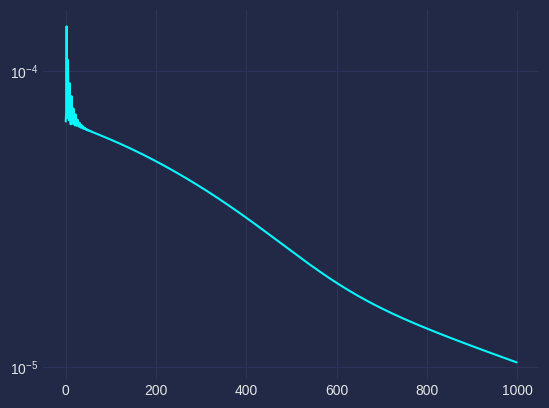

In [37]:
#training loop
pbar = tqdm.tqdm(range(epocas), desc="Training",  colour='cyan', ncols=100)

errores=[]
for i in pbar:
    l=cost(T) #coste
    #l=torch.nn.MSELoss(Param(T))
    l.backward() #gradiente
    optimizer.step() #se actualizan los parámetros
    optimizer.zero_grad() #vacíamos el gradiente
    #print('época=%.2f , loss=%.2f'%(i,l))
    errores.append(float(l))
    #tqdm.set_description('época: %d , loss: %.2f' % (i, l.item()))
    pbar.set_postfix({'loss': l.item()})
    #pbar.set_refresh(50)
    #tqdm.set_description("Training")
    #print('época=%.2f , loss=%.2f'%(i,l))

plt.plot(range(epocas),errores)
plt.yscale('log')

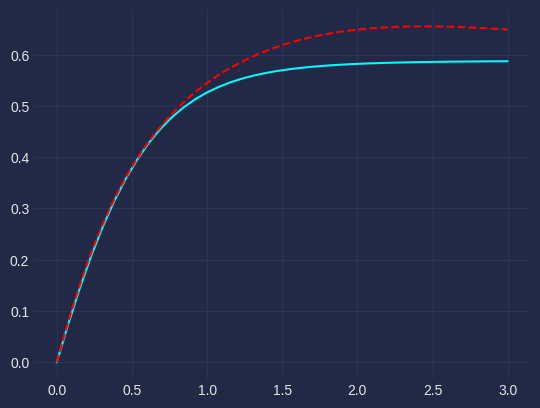

In [42]:
#pos_ini=0.2

#solución real
omega_0 = -1.0
omega_a = 7.0
z=np.linspace(0,3,40)
plt.plot(z,DL(z))


z0 = torch.linspace(zi,zf,60)
Omega0 = omega_0*torch.ones([z0.shape[0],1])
Omegaa = omega_a*torch.ones([z0.shape[0],1])
#v0 = vel_ini*torch.ones([t0.shape[0],1])
# delta0 = d*torch.ones([t0.shape[0],1])
# omega0 = omega*torch.ones([t0.shape[0],1])

X=torch.cat((z0.view(-1,1),Omega0,Omegaa),1)
#X.cuda()
#plt.plot(t0, -torch.sin(t0)+2*t0+pos_ini, label='solución real')
#plt.plot(z0.detach(), sol_x([pos_ini,vel_ini], t0, d, omega), label='solución real')
#plt.plot(z0,pos_ini * (z0+1)**3, label='Solution')
plt.plot(z0,Param(X).detach().numpy(),'--r', label='PINN')

#plt.plot(t0.view(-1,1),Param(t0.view(-1,1)).detach().numpy(),'--r', label='PINN')
#plt.legend()

In [43]:
%timeit Param(X).detach().numpy()

188 µs ± 5.06 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [44]:
#%timeit sol_x([pos_ini,vel_ini], t0, d, omega) #odeint

In [45]:
torch.save(ANN.state_dict(),'CPL_param_dict')

---
### For evaluating the model, and perform a benchmarking we use:

In [49]:
nodos=16
ANN_CPL = nn.Sequential(nn.Linear(3, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos)
                    nn.Tanh(),nn.Linear(nodos,1))
print(ANN_CPL)

Sequential(
  (0): Linear(in_features=3, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
)


In [50]:
ANN_CPL.load_state_dict(torch.load('CPL_param_dict'))
ANN_CPL.eval()

Sequential(
  (0): Linear(in_features=3, out_features=16, bias=True)
  (1): Tanh()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): Tanh()
  (4): Linear(in_features=16, out_features=1, bias=True)
)

In [51]:
z_mesh = np.linspace(zi, zf, 100)
O0_mesh = [-2.0,-1.0,0.0,1.0]
Oa_mesh = np.linspace(omega_ai, omega_af, 100)

z_param = torch.linspace(zi, zf, 100)
#O0_param = torch.linspace(x0_i, x0_f, 100)
Oa_param = torch.linspace(omega_ai, omega_af, 100)

mesh=np.ones((100,100))

In [67]:

mapas=[]
for O0i in O0_mesh:
    mesh=np.ones((100,100))
    for i in range(100):
        for j in range(100):
            a=Param(torch.tensor([[z_param[i],Oa_param[j],O0i]]), net=ANN_CPL).detach().numpy()
            #b=sol_x([x0_mesh[j],1.0], [z_mesh[i]], 1.5, 3.0)
            omega_0 = O0i
            omega_a = Oa_mesh[j]
            #plt.plot(z,DL(z))
            b=DL([z_mesh[i]])
            
            mesh[i,j] =  abs(a-b)/abs(b) * 100.0
    mapas.append(mesh)

/tmp/ipykernel_27634/4056165852.py:13: RuntimeWarning: invalid value encountered in divide
  mesh[i,j] =  abs(a-b)/abs(b) * 100.0


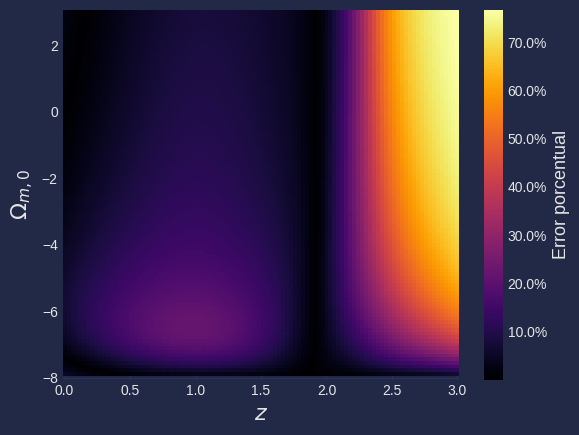

In [68]:
fig, ax = plt.subplots()

# Creamos la barra de densidad
pcolormesh = ax.pcolormesh(z_mesh, Oa_mesh, mapas[1], cmap='inferno')

# Modificamos la función `colorbar` para que muestre el símbolo de porcentaje
colorbar = plt.colorbar(pcolormesh, format='%1.1f%%')
colorbar.ax.set_ylabel('Error porcentual', size=13)
ax.set_xlabel('$z$', size=16)
ax.set_ylabel('$\Omega_{m,0}$', size=16)
# Mostramos la gráfica
plt.show()
#plt.savefig()
#fig.savefig('L-CDM.pdf')

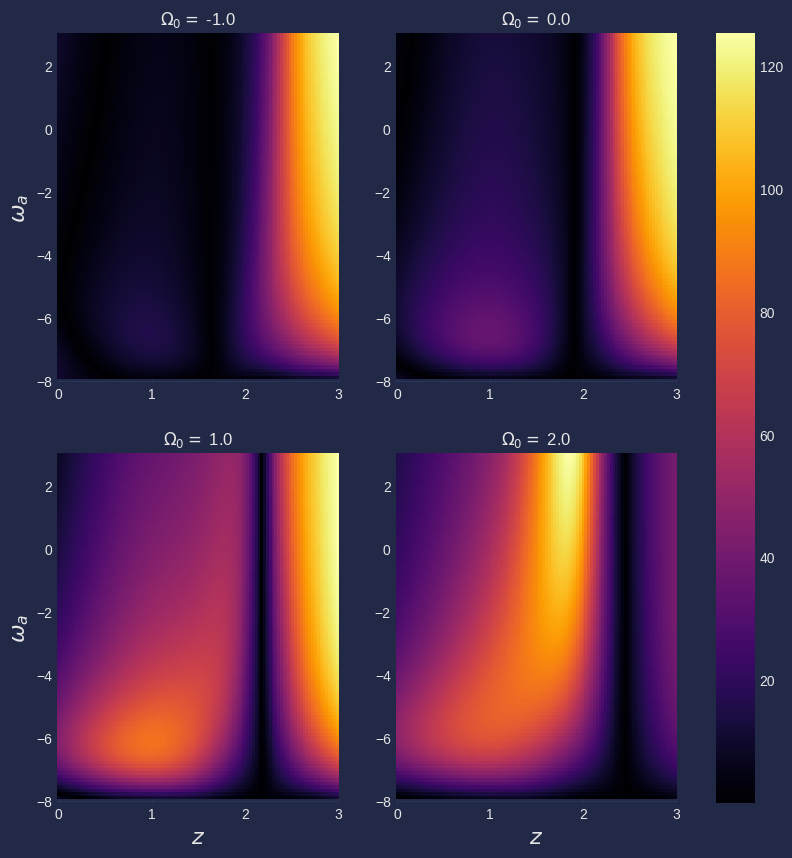

In [103]:
# Creamos la figura y las subfiguras
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Recorremos los mapas y los graficamos
for i, o0 in enumerate(O0_mesh):
    ax = axes[i // 2, i % 2]
    
    # Graficamos el mapa de densidad
    pcolormesh = ax.pcolormesh(z_mesh, Oa_mesh,mapas[i], cmap='inferno')
    
    # Añadimos la barra de color
    #colorbar = plt.colorbar(pcolormesh, ax=ax)

    # Personalizamos la subfigura
    ax.set_title(f"$\Omega_0 =$ {o0 + 1}")
    if i==2 or i==3: ax.set_xlabel('$z$', size=16)
    if i==0 or i==2:ax.set_ylabel('$\omega_a$', size=16)

fig.colorbar(pcolormesh, ax=axes.ravel().tolist())

# Mostramos la figura
plt.show()
fig.savefig('CPL.pdf')